In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

### Read in samples for origin ARS315, set up the annotation of the nucleosome areas

## Wildtype

In [1]:
load_dir =  "ARS315"

In [2]:
ls ARS315/

ARS315_disw2_rep1_780READS.csv
ARS315_disw2_rep1_780READS_noNA.csv
ARS315_disw2_rep2_780READS.csv
ARS315_disw2_rep2_780READS_noNA.csv
ARS315_starting_LexA  (31 .. 1277).dna
ARS315_starting_LexA  (31 .. 1277).fa
DIES6_ALL_REP1_ARS315_starting_LexA.txt
DIES6_ARS315_REP2_780READS.csv
Features from ARS315_starting_LexA  (31 .. 1277).txt
mat_Megalodon_repII_ARS315_starting_LexA.txt
wt_mat_Megalodon_repIII_ARS315_starting_LexA.txt


In [5]:
wt_rep3 = np.loadtxt(load_dir + "/wt_mat_Megalodon_repIII_ARS315_starting_LexA.txt")

#replicate 2
wt_rep2 = np.loadtxt(load_dir + "/mat_Megalodon_repII_ARS315_starting_LexA.txt")

#feature annotation
anno = pd.read_csv(load_dir + "/Features from ARS315_starting_LexA  (31 .. 1277).txt", sep  = "\t", 
                          header = None, index_col = 0)
anno.columns = ["position", "length"]
anno.index = anno.index.astype("string")
anno.index = anno.index.str.strip()

anno["pos_start"] = anno.position.str.split(".").str[0].astype(int) -1
anno["pos_stop"] = anno.position.str.split(".").str[2].astype(int) -1

ValueError: Wrong number of columns at line 698

In [11]:
anno

,position,length,pos_start,pos_stop
0,,,,
NS-3,135..281,147,134,280
L-2,282..291,10,281,290
NS-2,292..438,147,291,437
L-1,439..440,2,438,439
NS-1,441..587,147,440,586
ARS316,543..786,244,542,785
NS+1,733..879,147,732,878
L+1,880..916,37,879,915
NS+2,917..1063,147,916,1062


In [12]:
wt_rep2.shape[1] == wt_rep3.shape[1]

True

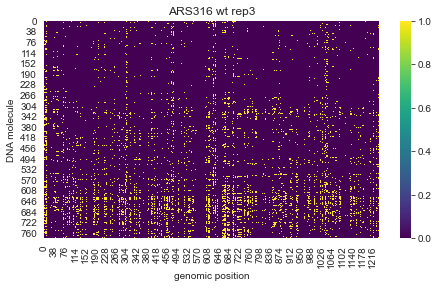

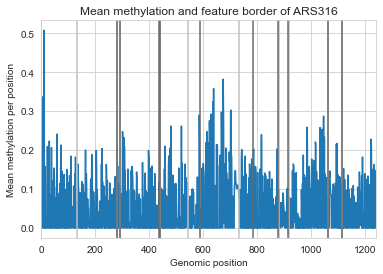

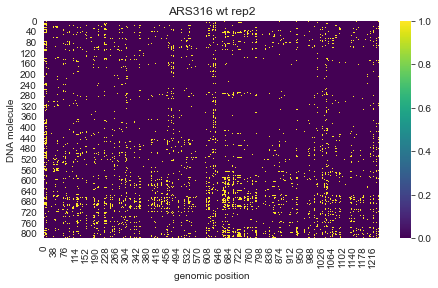

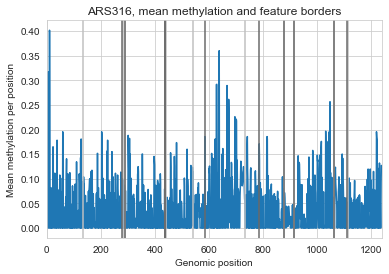

In [51]:
#plot the raw data:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep3")
plt.show()

#and the bulk data:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep3.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

#wildtype replicate 2:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep2")
plt.show()

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep2.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title(load_dir + ", mean methylation and feature borders")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

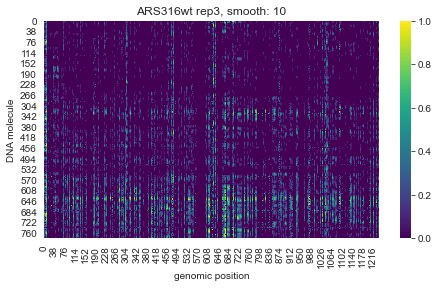

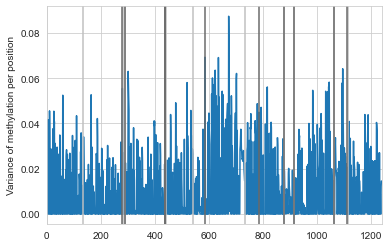

In [14]:
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)
    
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_smooth, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + "wt rep3, smooth: " + str(smooth_window))
plt.show()

sns.lineplot(x = range(wt_rep3_smooth.shape[1]), 
                 y = wt_rep3_smooth.std(axis = 0)**2
                )
plt.ylabel("Variance of methylation per position")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

In [15]:
#sns.lineplot(x = wt_rep3.shape[1], y = 100 * wt_rep3.cumsum(axis = 0)wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1])

#wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :].shape
100 * wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1]

array([8.87812752, 0.        , 0.        , ..., 0.        , 7.26392252,
       9.28167877])

In [49]:
#this computes the percent of methylation at a specific base
wt_rep3.cumsum(axis = 0)/wt_rep3.shape[1]

#as a measure for the heterogeneity, try the entropy:
# alternatively, try: from scipy.stats import entropy

def entropy(labels, base=None):
    base = math.e if base is None else base
    _ ,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()

    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

#https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

<AxesSubplot:title={'center':'ARS316 wt rep3, entropy per position'}, ylabel='entropy'>

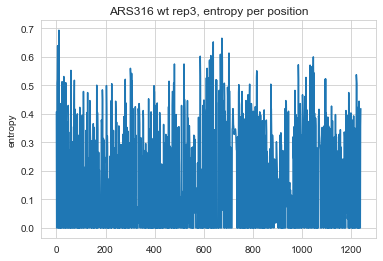

In [17]:
g = sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3))
g.set_ylabel("entropy")
g.set_title(load_dir + " wt rep3, " + "entropy per position")
#g.set_xticks(range(0, ARS305_wt.shape[1], 50))
g

In [18]:
entropy_wt_rep3 = np.apply_along_axis(entropy, 0, wt_rep3)
entropy_wt_rep3.min(), entropy_wt_rep3.max(), np.count_nonzero(entropy_wt_rep3)

(-0.0, 0.6930288326958663, 657)

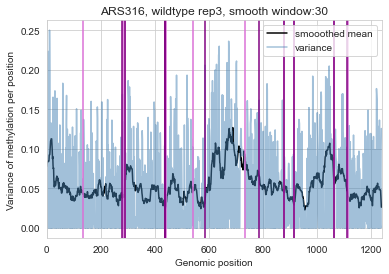

In [19]:
N = 30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(N)/N, mode ="same"),
             color = "black", label = "smooothed mean")
#plt.ylabel("Mean methylation over sample")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir +  ", wildtype rep3, smooth window:" + str(N))


sns.lineplot(x = range(wt_rep3.shape[1]), 
            y = wt_rep3.std(axis = 0)**2, color = "steelblue", alpha = 0.5,
            label = "variance"
            )
plt.ylabel("Variance of methylation per position")
plt.xlabel("Genomic position")
#plt.axvline(62, color = "purple", label = "border")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "orchid")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "purple")

## Load data for mutant dies6

(83, 1239)


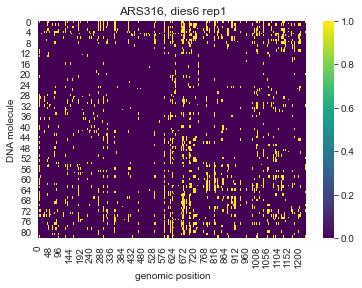

(301, 1239)


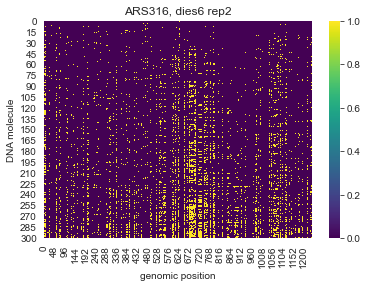

In [24]:
dies6_rep1 = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS316_end_LexA.txt")
print(dies6_rep1.shape)

sns.heatmap(dies6_rep1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

dies6_rep2 = np.genfromtxt(load_dir + "/DIES6_ARS316_REP2_301READS.csv", dtype = int, delimiter = ",")
print(dies6_rep2.shape)

sns.heatmap(dies6_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

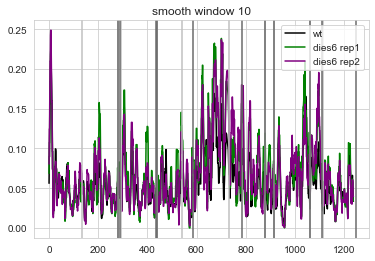

(119189.0, 3.612282192766277e-98)

In [25]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "dies6 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

wt_rep3_smooth_mean = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((wt_rep3_smooth_mean.reshape(1, wt_rep3.shape[1]), 
                        dies6_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        dies6_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                              axis = 0)

from scipy.stats import wilcoxon

w, p = wilcoxon(means[0,:], means[1,:], alternative = "two-sided")
w,p

In [26]:
#statistical test to compare replicates of the mutants: 
wilcoxon(dies6_rep1.mean(axis = 0), 
         dies6_rep2.mean(axis = 0), alternative = "two-sided")

WilcoxonResult(statistic=92016.0, pvalue=0.017348296472827325)

## Load data for mutant disw2

In [27]:
ls ARS316/

ARS316_disw2_rep1_301READS.csv
ARS316_disw2_rep1_301READS_noNA.csv
ARS316_disw2_rep1_780READS.csv
ARS316_disw2_rep1_780READS_noNA.csv
ARS316_disw2_rep2_301READS.csv
ARS316_disw2_rep2_301READS_noNA.csv
ARS316_disw2_rep2_780READS.csv
ARS316_disw2_rep2_780READS_noNA.csv
ARS316_end_LexA  (31 .. 1280).dna
ARS316_end_LexA  (31 .. 1280).fa
DIES6_ALL_REP1_ARS316_end_LexA.txt
DIES6_ARS316_REP2_301READS.csv
Features_from_ARS316_end_LexA _(31 .. 1280).txt
mat_Megalodon_repII_ARS316_end_LexA.txt
wt_mat_Megalodon_repIII_ARS316_end_LexA.txt
wt_mat_Megalodon_repIII_ARS316_end_LexA_301READS.txt


(780, 1239)


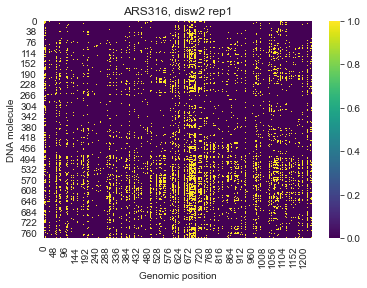

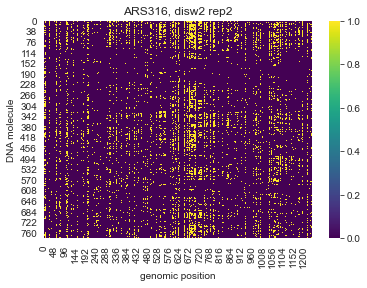

In [28]:
disw2_rep1 = np.genfromtxt(load_dir + "/ARS316_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
print(disw2_rep1.shape)

sns.heatmap(disw2_rep1, cmap = "viridis")
plt.xlabel("Genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep1.shape[1])
plt.title(load_dir + ", disw2 rep1")
plt.show()

disw2_rep2 = np.genfromtxt(load_dir + "/ARS316_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")
disw2_rep2.shape

sns.heatmap(disw2_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep2.shape[1])
plt.title(load_dir + ", disw2 rep2")
plt.show()

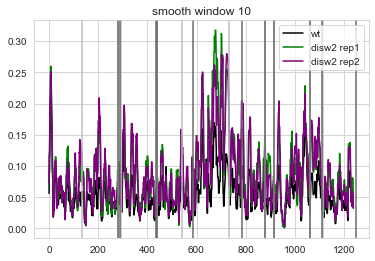

In [29]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "disw2 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [30]:
# calculate the mean over all molecules and smooth with window size "smooth"

disw2_rep1_smooth_mean = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
disw2_rep2_smooth_mean = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((means, 
                        disw2_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        disw2_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                        axis = 0)

w, p = wilcoxon(disw2_rep1.mean(axis = 0),
                disw2_rep2.mean(axis = 0), alternative = "two-sided")
w,p

(103082.0, 0.9254377042917336)

## Condense segment information for statistical testing of methylation per feature window

In [31]:
segments = anno.drop(columns = "position")

#list comprehension to catch the smoothed methylation values per sample in a cell per column
array_list = [wt_rep3_smooth_mean[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_rep3_smooth_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_smooth_mean[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_rep1_smooth_mean"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_smooth_mean[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_rep2_smooth_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [disw2_rep1_smooth_mean[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_rep1_smooth_mean"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_smooth_mean[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_rep2_smooth_mean"] = pd.Series(array_list, index = segments.index)

In [32]:
#this chunk doesn't work yet, it should catch the values per sample automatically from a list of samples
#samples = [ARS305_wt_smooth_mean, ARS305_dies6_rep1_smooth_mean, ARS305_dies6_rep2_smooth_mean]

#ARS305_segments = ARS305_anno.drop(columns = "position")

#for sample in samples:
#    temp_array_list = [samples[ARS305_segments.loc[index, "pos_start"]:ARS305_segments.loc[index, "pos_stop"]] for
#                  index in ARS305_segments.index]
#    #print(temp_array_list)
#    ARS305_segments[sample] = pd.Series(temp_array_list, index = ARS305_segments.index)   

In [33]:
#ARS305_segments.drop(index = ["L+2", "L-1"], inplace = True)

segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_rep3_smooth_mean"], 
                                           segments.loc[index,"dies6_rep1_smooth_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_rep3_smooth_mean"], 
                                           segments.loc[index,"dies6_rep2_smooth_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_rep3_smooth_mean"], 
                                           segments.loc[index,"disw2_rep1_smooth_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_rep3_smooth_mean"], 
                                           segments.loc[index,"disw2_rep2_smooth_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

In [34]:
print("           Overview of p-values for different mutants")
print("           Smoothing window: " + str(smooth_window))
segments.drop(segments.columns[3:8], axis =1)

           Overview of p-values for different mutants
           Smoothing window: 10


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-3,147,134,280,3.249654e-02,4.670157e-07,4.037865e-19,2.143013e-25
L-2,10,281,290,3.906250e-03,3.906250e-03,3.906250e-03,3.906250e-03
NS-2,147,291,437,8.790410e-20,3.209870e-09,1.255179e-25,2.399222e-25
L-1,2,438,439,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
NS-1,147,440,586,1.409846e-10,1.336025e-06,1.350760e-19,6.651723e-22
ARS316,244,542,785,4.031441e-35,3.075984e-32,1.242190e-38,1.759927e-39
NS+1,147,732,878,2.358738e-23,9.282069e-20,1.109717e-25,6.203774e-25
L+1,37,879,915,1.678829e-07,1.678829e-07,1.678829e-07,1.678829e-07
NS+2,147,916,1062,6.492384e-11,9.680852e-05,1.650556e-22,3.044383e-23


In [35]:
#Regions significant for disw2:
pvalue = 2.5e-2

test = segments.drop(segments.columns[3:8], axis =1)

print("       Which sites have a different mean methylation for the disw2 mutatant?")
test.loc[(test["p_value_disw2_rep1"] < pvalue) & 
         (test["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation for the disw2 mutatant?


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-3,147,134,280,3.249654e-02,4.670157e-07,4.037865e-19,2.143013e-25
L-2,10,281,290,3.906250e-03,3.906250e-03,3.906250e-03,3.906250e-03
NS-2,147,291,437,8.790410e-20,3.209870e-09,1.255179e-25,2.399222e-25
NS-1,147,440,586,1.409846e-10,1.336025e-06,1.350760e-19,6.651723e-22
ARS316,244,542,785,4.031441e-35,3.075984e-32,1.242190e-38,1.759927e-39
NS+1,147,732,878,2.358738e-23,9.282069e-20,1.109717e-25,6.203774e-25
L+1,37,879,915,1.678829e-07,1.678829e-07,1.678829e-07,1.678829e-07
NS+2,147,916,1062,6.492384e-11,9.680852e-05,1.650556e-22,3.044383e-23
L+2,50,1063,1112,1.107224e-09,1.107224e-09,1.107224e-09,1.107224e-09


In [36]:
#Regions significant for dies6:
pvalue = 2.5e-2

test = segments.drop(segments.columns[3:8], axis =1)

print("       Which sites have a different mean methylation for the disw2 mutatant?")
test.loc[(test["p_value_dies6_rep1"] < pvalue) & 
         (test["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation for the disw2 mutatant?


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
L-2,10,281,290,3.906250e-03,3.906250e-03,3.906250e-03,3.906250e-03
NS-2,147,291,437,8.790410e-20,3.209870e-09,1.255179e-25,2.399222e-25
NS-1,147,440,586,1.409846e-10,1.336025e-06,1.350760e-19,6.651723e-22
ARS316,244,542,785,4.031441e-35,3.075984e-32,1.242190e-38,1.759927e-39
NS+1,147,732,878,2.358738e-23,9.282069e-20,1.109717e-25,6.203774e-25
L+1,37,879,915,1.678829e-07,1.678829e-07,1.678829e-07,1.678829e-07
NS+2,147,916,1062,6.492384e-11,9.680852e-05,1.650556e-22,3.044383e-23
L+2,50,1063,1112,1.107224e-09,1.107224e-09,1.107224e-09,1.107224e-09
NS+3,137,1113,1249,2.199850e-11,2.687377e-04,2.025291e-22,2.483568e-21


In [37]:
#Repeat this test for the hypothesis that methylation in one fragment is higher than in wildtype:
test_higher = segments.iloc[:, :8]
test_higher["p_value_dies6_rep1"] = [wilcoxon(test_higher.loc[index, "wt_rep3_smooth_mean"], 
                                           test_higher.loc[index,"dies6_rep1_smooth_mean"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_dies6_rep2"] = [wilcoxon(test_higher.loc[index, "wt_rep3_smooth_mean"], 
                                           test_higher.loc[index,"dies6_rep2_smooth_mean"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep1"] = [wilcoxon(test_higher.loc[index, "wt_rep3_smooth_mean"], 
                                           test_higher.loc[index,"disw2_rep1_smooth_mean"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep2"] = [wilcoxon(test_higher.loc[index, "wt_rep3_smooth_mean"], 
                                           test_higher.loc[index,"disw2_rep2_smooth_mean"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher.drop(segments.columns[3:8], axis =1, inplace = True)

In [38]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the dies6 mutant?")
test_higher.loc[(test_higher["p_value_dies6_rep1"] < pvalue) & 
         (test_higher["p_value_dies6_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the dies6 mutant?


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-3,147,134,280,1.624827e-02,2.335079e-07,2.018933e-19,1.071506e-25
L-2,10,281,290,1.953125e-03,1.953125e-03,1.953125e-03,1.953125e-03
NS-2,147,291,437,4.395205e-20,1.604935e-09,6.275896e-26,1.199611e-25
NS-1,147,440,586,7.049231e-11,6.680127e-07,6.753799e-20,3.325861e-22
ARS316,244,542,785,2.015721e-35,1.537992e-32,6.210952e-39,8.799637e-40
NS+1,147,732,878,1.179369e-23,4.641035e-20,5.548585e-26,3.101887e-25
L+1,37,879,915,8.394144e-08,8.394144e-08,8.394144e-08,8.394144e-08
NS+2,147,916,1062,3.246192e-11,4.840426e-05,8.252778e-23,1.522191e-23
L+2,50,1063,1112,5.536118e-10,5.536118e-10,5.536118e-10,5.536118e-10


In [39]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the disw2 mutant?")
test_higher.loc[(test_higher["p_value_disw2_rep1"] < pvalue) & 
         (test_higher["p_value_disw2_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the disw2 mutant?


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-3,147,134,280,1.624827e-02,2.335079e-07,2.018933e-19,1.071506e-25
L-2,10,281,290,1.953125e-03,1.953125e-03,1.953125e-03,1.953125e-03
NS-2,147,291,437,4.395205e-20,1.604935e-09,6.275896e-26,1.199611e-25
NS-1,147,440,586,7.049231e-11,6.680127e-07,6.753799e-20,3.325861e-22
ARS316,244,542,785,2.015721e-35,1.537992e-32,6.210952e-39,8.799637e-40
NS+1,147,732,878,1.179369e-23,4.641035e-20,5.548585e-26,3.101887e-25
L+1,37,879,915,8.394144e-08,8.394144e-08,8.394144e-08,8.394144e-08
NS+2,147,916,1062,3.246192e-11,4.840426e-05,8.252778e-23,1.522191e-23
L+2,50,1063,1112,5.536118e-10,5.536118e-10,5.536118e-10,5.536118e-10


### Min-max normalise each experiment and pool replicates

In [40]:
wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

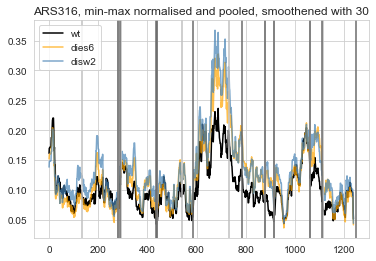

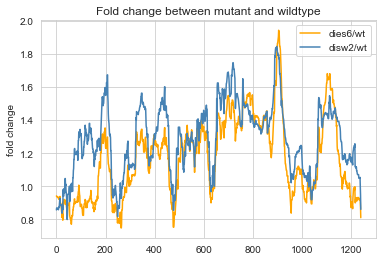

In [41]:
N=30

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "orange", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "steelblue", alpha = 0.7,
            label = "disw2")
plt.title(load_dir +  ", min-max normalised and pooled, smoothened with " + str(N)) #pooled and min-max normalised
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "orange", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "steelblue",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
plt.show()

### Compare pooled wildtype to mutant replicates, then filter regions

In [42]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep2"] = pd.Series(array_list, index = segments.index)


#disw2 mutant
array_list = [disw2_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep2"] = pd.Series(array_list, index = segments.index)

In [43]:
#perform statistical test
segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments.drop(segments.columns[3:8], axis =1, inplace = True)

/Users/karoline.holler/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [44]:
segments

,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-3,147,134,280,2.679665e-01,9.714944e-01,3.318877e-01,5.975980e-06
L-2,10,281,290,6.858304e-01,8.927384e-01,5.001843e-01,7.961580e-02
NS-2,147,291,437,1.253442e-03,7.989636e-04,3.241538e-05,5.551556e-09
L-1,2,438,439,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
NS-1,147,440,586,2.022930e-02,6.627290e-02,4.125163e-02,5.481820e-05
ARS316,244,542,785,3.219991e-09,5.337636e-12,1.165648e-10,4.690127e-13
NS+1,147,732,878,3.875380e-06,1.986880e-08,3.767115e-08,4.863376e-09
L+1,37,879,915,1.432609e-03,1.514489e-05,3.084039e-05,5.856266e-06
NS+2,147,916,1062,3.376614e-01,2.014036e-01,1.357685e-01,3.094484e-05


In [45]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6_rep1"] < pvalue) &
            (segments["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-2,147,291,437,1.253442e-03,7.989636e-04,3.241538e-05,5.551556e-09
ARS316,244,542,785,3.219991e-09,5.337636e-12,1.165648e-10,4.690127e-13
NS+1,147,732,878,3.875380e-06,1.986880e-08,3.767115e-08,4.863376e-09
L+1,37,879,915,1.432609e-03,1.514489e-05,3.084039e-05,5.856266e-06
L+2,50,1063,1112,1.066709e-03,1.542669e-06,2.038892e-06,8.751280e-07


In [46]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2_rep1"] < pvalue) &
            (segments["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-2,147,291,437,1.253442e-03,7.989636e-04,3.241538e-05,5.551556e-09
ARS316,244,542,785,3.219991e-09,5.337636e-12,1.165648e-10,4.690127e-13
NS+1,147,732,878,3.875380e-06,1.986880e-08,3.767115e-08,4.863376e-09
L+1,37,879,915,1.432609e-03,1.514489e-05,3.084039e-05,5.856266e-06
L+2,50,1063,1112,1.066709e-03,1.542669e-06,2.038892e-06,8.751280e-07
NS+3,137,1113,1249,1.013283e-01,3.883076e-01,2.518451e-05,6.357334e-05


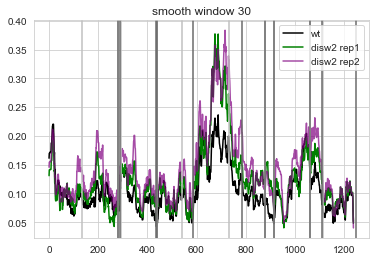

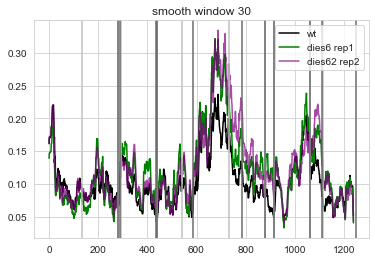

In [47]:
# How does that look over the whole sequence?
smooth_width = 30

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "purple", alpha = 0.7, label = "disw2 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "purple", alpha = 0.7, label = "dies62 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [48]:
anno

,position,length,pos_start,pos_stop
0,,,,
NS-3,135..281,147,134,280
L-2,282..291,10,281,290
NS-2,292..438,147,291,437
L-1,439..440,2,438,439
NS-1,441..587,147,440,586
ARS316,543..786,244,542,785
NS+1,733..879,147,732,878
L+1,880..916,37,879,915
NS+2,917..1063,147,916,1062
